In [ ]:
import sys
import numpy as np
from scripts.contaminant_utils import *
from path import Path

# Contaminant Analysis

## TODO:
* generate contaminant reports for historical analysis 
    * ask KG for permission access to write HTML report files 
* plot heatmap w/ bar chart outside showing contamination flags (or another heatmap on top) [done]
* sort barcode-sample pairs to make heatmap more intuitive to read [done]
    * isolate completed paired reads
    * identify mapping between complete paired reads and sample ID
    * flank each complete paired read by its unknown sisters
    
* mapped reads are ones that align with the Sar-CoV2 genome, unmapped are ones that may come from human or other external samples
* generate plot of ratio of coverage versus ratio of mapped-to-unmapped reads [done]
* create conda env to run whole of snakemake pipeline [WIP]
    * clean YAML to include only necessary dependencies [done]
    * investigate installing iVar 1.2.2 via conda [done]
    * investigate creating a YAML file that works for both Linux and MacOS
* Variants analysis
    * plot `ALT_FREQ` vs `POS`, color coded based on synonymous/non-synonymous variants
    * grab data from `\*.tsv` files in `variants/`
    
* workflow
    * emacs as text editor
        * get config file from GK
    * try VS Code
    * try Vim
    

In [2]:
sample_pths = !find /home/gk/analysis/ -name "barcode_counts" -type d
sample_pths = [Path(p)/'illumina' for p in sample_pths]

In [3]:
sample_pths[8]

Path('/home/gk/analysis/2020.07.07.hCoV19/barcode_counts/illumina')

In [5]:
data_pth = sample_pths[8]
input_pths = data_pth.listdir()
out_pth = data_pth
num_samples = len(input_pths)
# grab data from each sample
ans = load_all_data(input_pths)
# generate paired reads
ans['paired_read'] = ans.apply(lambda x: x['forward_barcode'] + '-' + x['reverse_barcode'], axis=1)
# compute log of read counts 
ans['log_count'] = ans['paired_read_count'].apply(lambda x: np.log(x+1))
# generate heatmap matrix of (logged: optional) read counts per sample per paired read
hmap, data, x, y = get_heatmap_data(ans)
general_hmap = generate_heatmap(data, x, y)
# generate heatmap matrix of only samples suspected of contamination
cont_data, cont_x, cont_y = get_contaminated_data(data, hmap)
cont_hmap = generate_heatmap(cont_data, cont_x, cont_y)
# table of barcode read counts for contaminated samples only
cont_table = generate_table(ans, cont_x)
# number of contaminated samples
num_conts = len(cont_x)
# generate scatter plot of coverage vs mapped reads ratio
mapped_pth = Path('/home/gk/analysis/2020.08.10.hCoV19/merged_aligned_bams/illumina/reports/mapped_unmapped_report.tsv')
coverage_pth = Path('/home/gk/analysis/2020.08.10.hCoV19/trimmed_bams/illumina/reports/coverage_report.tsv')
mapped_df = pd.read_csv(mapped_pth, delimiter='\t')
mapped_df['mapped ratio'] = mapped_df['mapped'] / mapped_df['unmapped']
mapped_df['SAMPLE'] = mapped_df['SAMPLE'].apply(lambda x: x.split('/')[-1].split('_')[0])
coverage_df = pd.read_csv(coverage_pth, delimiter='\t')
coverage_df['SAMPLE'] = coverage_df['SAMPLE'].apply(lambda x: x.split('_')[0])
scattr_df = pd.merge(mapped_df, coverage_df, on='SAMPLE', how='inner')[['SAMPLE', 'COVERAGE', 'mapped ratio']]
def generate_scatter(df: pd.DataFrame):
    df['contaminated'] = 0
    df.loc[df['SAMPLE'].isin(cont_x), 'contaminated'] = 1
    cont_df = df.loc[df['contaminated']==1]
    norm_df = df.loc[df['contaminated']==0]
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=norm_df['mapped ratio'],
        y=norm_df['COVERAGE'],
        mode='markers',
        text=norm_df['SAMPLE'],
        marker_color='dark blue',
        name="Not Contaminated"
    ))

    fig.add_trace(go.Scatter(
        x=cont_df['mapped ratio'],
        y=cont_df['COVERAGE'],
        mode='markers',
        text=cont_df['SAMPLE'],
        marker_color='yellow',
        name="Contaminated"
    ))

    fig.update_layout(title='Coverage versus Mapped Reads Ratio',
              xaxis_title="Ratio of Mapped Reads",
              yaxis_title="Coverage",
              template='plotly',
              height=800)
    return fig

scattr_plot = generate_scatter(scattr_df)
# scattr_plot = go.Figure(data=go.Scatter(x=ans['mapped ratio'],
#                             y=ans['COVERAGE'],
#                             mode='markers',
#                             marker_color=ans['contaminated'],
#                             text=ans['SAMPLE'])) # hover text goes here

# scattr_plot.update_layout(title='Coverage versus Mapped Reads Ratio',
#               xaxis_title="Ratio of Mapped Reads",
#               yaxis_title="Coverage",
#               template='plotly',
#               height=800)
# generate html string
html_output = generate_html(general_hmap, cont_hmap, cont_table,
                            num_samples, num_conts, out_pth)
# save report to file
save_html(html_output, 'contamination_report.html')

In [17]:
ans.loc[ans['sample']=='SEARCH-1171-SAN']

,forward_barcode,reverse_barcode,paired_read_count,sample,paired_read,log_count
0,BF4,BR17,3.0,SEARCH-1171-SAN,BF4-BR17,1.386294
1,BF4,unknown,45.0,SEARCH-1171-SAN,BF4-unknown,3.828641
2,unknown,BR17,23.0,SEARCH-1171-SAN,unknown-BR17,3.178054
3,unknown,unknown,182.0,SEARCH-1171-SAN,unknown-unknown,5.209486


In [39]:
mapped_df

,SAMPLE,mapped,unmapped,mapped ratio
0,SEARCH-1679-SAN,753687,3800927,0.198290
1,SEARCH-1993-SAN,37175,3197475,0.011626
2,SEARCH-1994-SAN,15396,4004724,0.003844
3,SEARCH-1995-SAN,45923,6953855,0.006604
4,SEARCH-1996-SAN,704304,18916,37.233242
...,...,...,...,...
273,SEARCH-2265-SAN,34803,3647749,0.009541
274,SEARCH-2266-SAN,326370,2054372,0.158866
275,SEARCH-2267-SAN,74733,7949363,0.009401
276,SEARCH-2268-SAN,1378814,22762,60.575257


In [42]:
mapped_df.loc[mapped_df['SAMPLE']=='SEARCH-2266-SAN']

,SAMPLE,mapped,unmapped,mapped ratio
274,SEARCH-2266-SAN,326370,2054372,0.158866


In [41]:
coverage_df.loc[coverage_df['SAMPLE']=='SEARCH-2266-SAN']

,SAMPLE,COVERAGE,AVG_DEPTH,MIN,MAX,ZERO_DEPTH
151,SEARCH-2266-SAN,97.0519,1407.2,0,42625,139


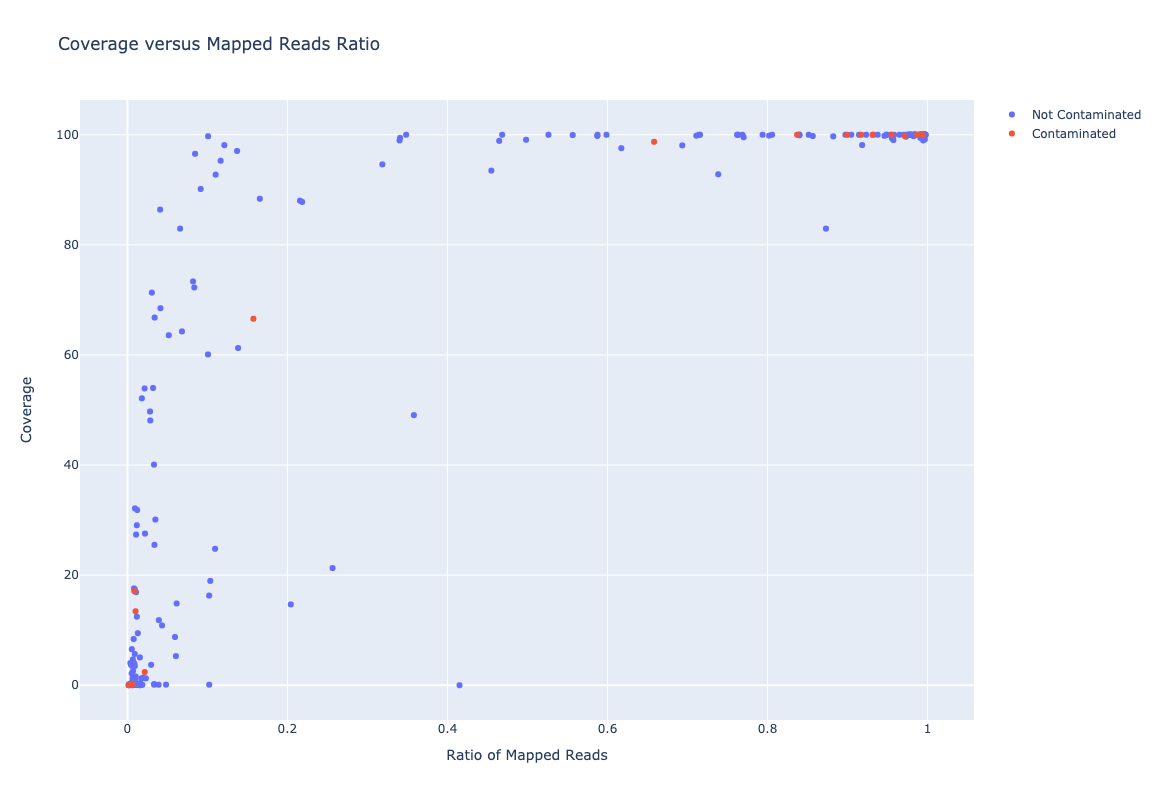

In [34]:
scattr_plot.show()

In [16]:
ans['contaminated'] = False
ans.loc[ans['SAMPLE'].isin(cont_x)] = True

In [17]:
ans['contaminated']

0      False
1      False
2      False
3      False
4      False
       ...  
273    False
274    False
275    False
276    False
277    False
Name: contaminated, Length: 278, dtype: bool

## Intra-host Variants

## Coverage versus Mapped reads

### Mapped and Unmapped reads

In [21]:
mapped = Path('/home/gk/analysis/2020.08.10.hCoV19/merged_aligned_bams/illumina/reports/mapped_unmapped_report.tsv')
mapped

Path('/home/gk/analysis/2020.08.10.hCoV19/merged_aligned_bams/illumina/reports/mapped_unmapped_report.tsv')

In [36]:
mapped_df = pd.read_csv(mapped, delimiter='\t')
mapped_df['mapped ratio'] = mapped_df['mapped'] / (mapped_df['unmapped']+mapped_df['mapped'])

In [37]:
mapped_df['SAMPLE'] = mapped_df['SAMPLE'].apply(lambda x: x.split('/')[-1].split('_')[0])
mapped_df

,SAMPLE,mapped,unmapped,mapped ratio
0,SEARCH-1679-SAN,753687,3800927,0.165478
1,SEARCH-1993-SAN,37175,3197475,0.011493
2,SEARCH-1994-SAN,15396,4004724,0.003830
3,SEARCH-1995-SAN,45923,6953855,0.006561
4,SEARCH-1996-SAN,704304,18916,0.973845
...,...,...,...,...
273,SEARCH-2265-SAN,34803,3647749,0.009451
274,SEARCH-2266-SAN,326370,2054372,0.137088
275,SEARCH-2267-SAN,74733,7949363,0.009314
276,SEARCH-2268-SAN,1378814,22762,0.983760


### Coverage

In [38]:
coverage = Path('/home/gk/analysis/2020.08.10.hCoV19/trimmed_bams/illumina/reports/coverage_report.tsv')
coverage

Path('/home/gk/analysis/2020.08.10.hCoV19/trimmed_bams/illumina/reports/coverage_report.tsv')

In [39]:
coverage_df = pd.read_csv(coverage, delimiter='\t')
coverage_df['SAMPLE'] = coverage_df['SAMPLE'].apply(lambda x: x.split('_')[0])

coverage_df

,SAMPLE,COVERAGE,AVG_DEPTH,MIN,MAX,ZERO_DEPTH
0,SEARCH-2014-SAN,0.0,0.070047,0,5,28036
1,SEARCH-2034-SAN,0.0,0.033051,0,8,28797
2,SEARCH-2046-SAN,0.0,0.029073,0,7,28979
3,SEARCH-2110-SAN,0.0,0.184127,0,5,25824
4,SEARCH-2239-SAN,0.0,0.192662,0,7,25759
...,...,...,...,...,...,...
273,SEARCH-2259-SAN,100.0,13757.000000,23,142194,0
274,SEARCH-2260-SAN,100.0,8822.150000,22,53506,0
275,SEARCH-2261-SAN,100.0,14847.800000,13,117819,0
276,SEARCH-2268-SAN,100.0,6114.030000,121,50207,0


In [40]:
ans = pd.merge(mapped_df, coverage_df, on='SAMPLE', how='inner')[['SAMPLE', 'COVERAGE', 'mapped ratio']]

In [41]:
ans

,SAMPLE,COVERAGE,mapped ratio
0,SEARCH-1679-SAN,88.37090,0.165478
1,SEARCH-1993-SAN,0.21082,0.011493
2,SEARCH-1994-SAN,0.10201,0.003830
3,SEARCH-1995-SAN,0.32303,0.006561
4,SEARCH-1996-SAN,100.00000,0.973845
...,...,...,...
273,SEARCH-2265-SAN,32.13640,0.009451
274,SEARCH-2266-SAN,97.05190,0.137088
275,SEARCH-2267-SAN,17.39260,0.009314
276,SEARCH-2268-SAN,100.00000,0.983760


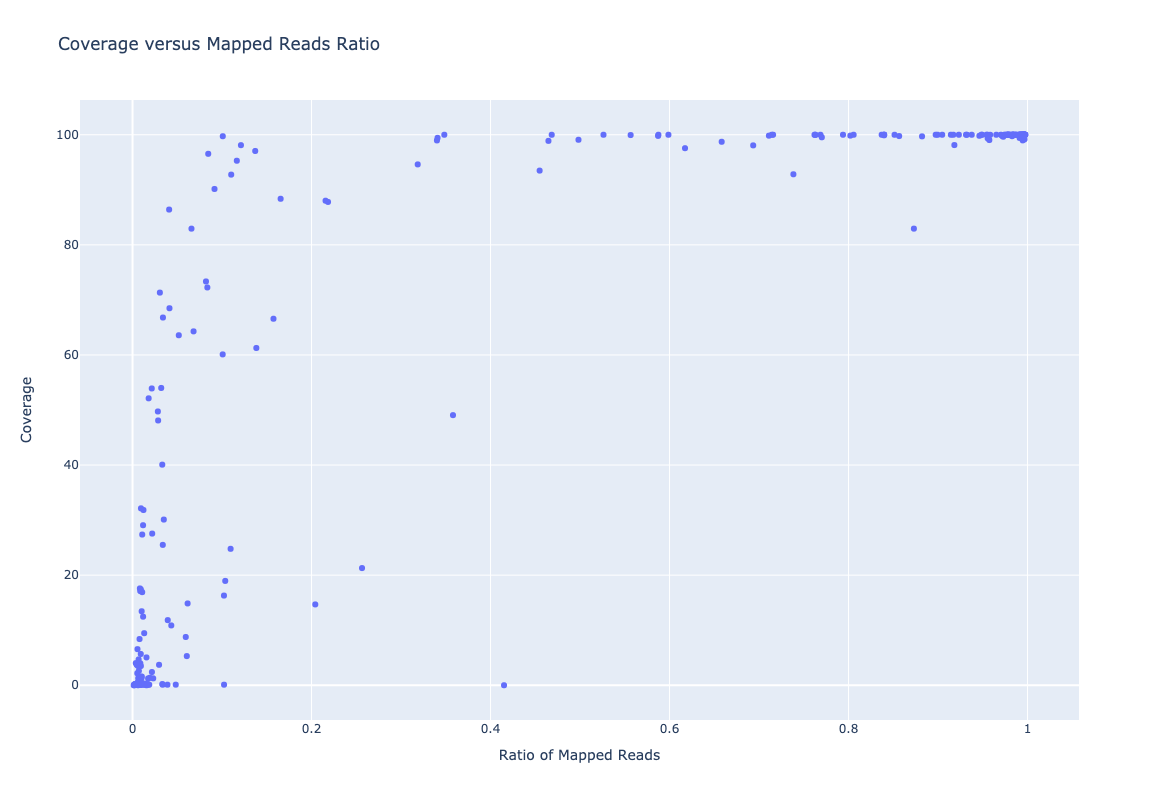

In [46]:
fig = go.Figure(data=go.Scatter(x=ans['mapped ratio'],
                                y=ans['COVERAGE'],
                                mode='markers',
                                text=ans['SAMPLE'])) # hover text goes here


fig.update_layout(title='Coverage versus Mapped Reads Ratio',
                  xaxis_title="Ratio of Mapped Reads",
                  yaxis_title="Coverage",
                  template='plotly',
                  height=800)
fig.show()

In [11]:
data_pth = sample_pths[5]
input_pths = data_pth.listdir()
input_pths

FileNotFoundError: [Errno 2] No such file or directory: Path('/home/gk/analysis/2020.04.02.hCoV19.archive/merged_aligned_bams/illumina/reports')

In [6]:
data_pth = sample_pths[5]
input_pths = data_pth.listdir()
out_pth = data_pth
num_samples = len(input_pths)
# grab data from each sample
ans = load_all_data(input_pths)
# generate paired reads
ans['paired_read'] = ans.apply(lambda x: x['forward_barcode'] + '-' + x['reverse_barcode'], axis=1)
# compute log of read counts 
ans['log_count'] = ans['paired_read_count'].apply(lambda x: np.log(x+1))
# generate heatmap matrix of (logged: optional) read counts per sample per paired read
hmap, data, x, y = get_heatmap_data(ans)
general_hmap = generate_heatmap(data, x, y)
# generate heatmap matrix of only samples suspected of contamination
cont_data, cont_x, cont_y = get_contaminated_data(data, hmap)
cont_hmap = generate_heatmap(cont_data, cont_x, cont_y)
# table of barcode read counts for contaminated samples only
cont_table = generate_table(ans, cont_x)
# number of contaminated samples
num_conts = len(cont_x)
# generate html string
html_output = generate_html(general_hmap, cont_hmap, cont_table,
                            num_samples, num_conts, out_pth)
# save report to file
save_html(html_output, 'contamination_report.html')

In [81]:
def generate_html(general_hmap, cont_hmap, cont_table, num_samples, num_conts, expt_name):
    # express plots in html and JS
    general_hmap = plotly.offline.plot(general_hmap, include_plotlyjs=False, output_type='div')
    cont_hmap = plotly.offline.plot(cont_hmap, include_plotlyjs=False, output_type='div')
    # express contaminants table in html
    cont_table = cont_table.to_html()
    # dir containing our template
    file_loader = FileSystemLoader('templates')
    # load the environment
    env = Environment(loader=file_loader)
    # load the template
    template = env.get_template('contamination.html')
    # render data in our template format
    html_output = template.render(general_hmap=general_hmap, cont_hmap=cont_hmap, 
                                  cont_table=cont_table, num_samples=num_samples,
                                  num_conts=num_conts, expt_name=expt_name)
    return html_output

In [36]:
def generate_heatmap(data, x, y, normalize=True):
    counts = data[:, :-1]
    if normalize:
        # normalize counts per sample (to address visualization issue) - IGNORE IF USING LOG
        summed_counts = counts.sum(axis=1)[:, np.newaxis]
        # normalize counts [OPTIONAL]
        counts_normed = counts / np.where(summed_counts > 0, summed_counts, 1)
    # grab column with contaminant flags
    flags = data[:, -1][:, np.newaxis]
    # generate plot
    fig = make_subplots(2,1, shared_xaxes=True)

    fig.add_trace(
     go.Heatmap(z = counts_normed.T, x = x, y = y, hovertext=counts.T, hovertemplate =
                '<b>Sample</b>: %{y}<br>'+
                '<b>Barcode</b>: %{x}<br>'+
                '<b>Count</b>: %{hovertext}<br>'+
                '<b>Normed Count</b>: %{z:.2f}',
                hoverinfo='all', coloraxis = "coloraxis"), 2,1)

    fig.add_trace(go.Heatmap(z = flags.T, x=x, y=['Contamination'], coloraxis = "coloraxis"),1,1)
    fig.update_layout(coloraxis = {'colorscale':'viridis'}, height=800,
        yaxis=dict(
            domain=[0.97, 1]
        ),
        yaxis2=dict(
            domain=[0, 0.95]
        )
    )
    return fig

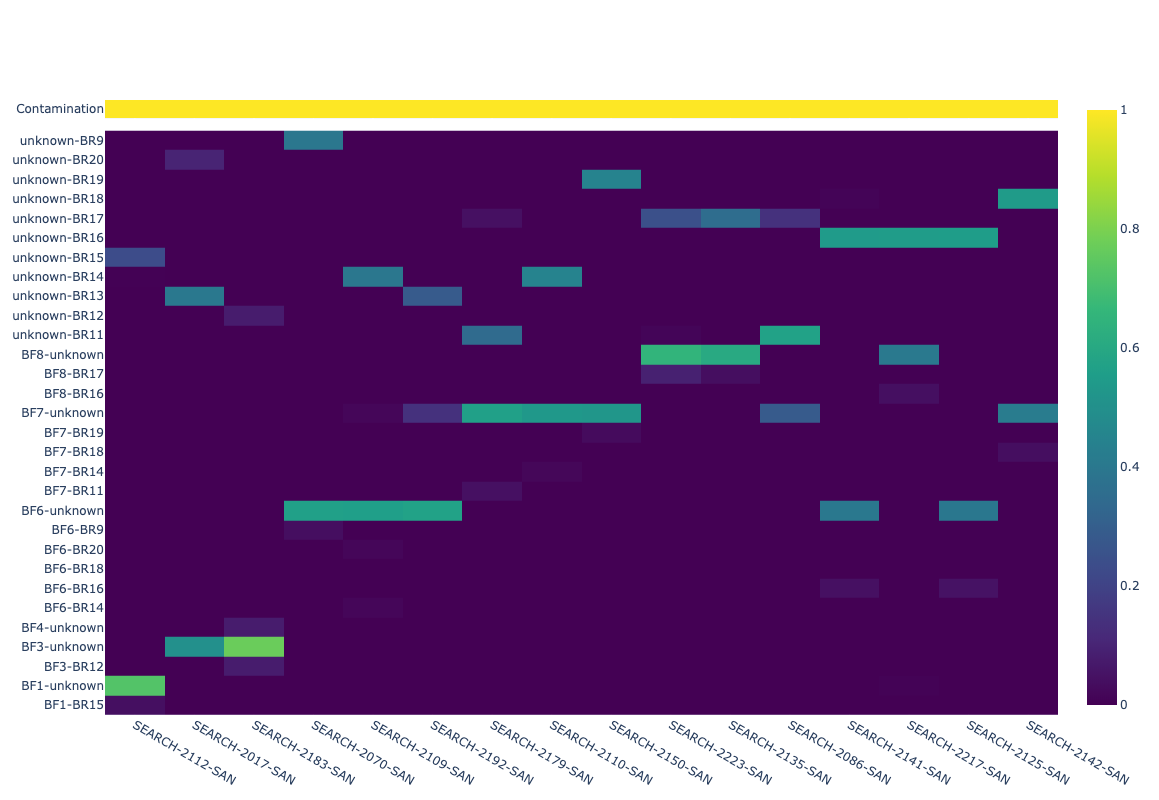

In [37]:
fig = generate_heatmap(cont_data, cont_x, cont_y)
fig.show()

In [78]:
fig = generate_heatmap(data, x, y)

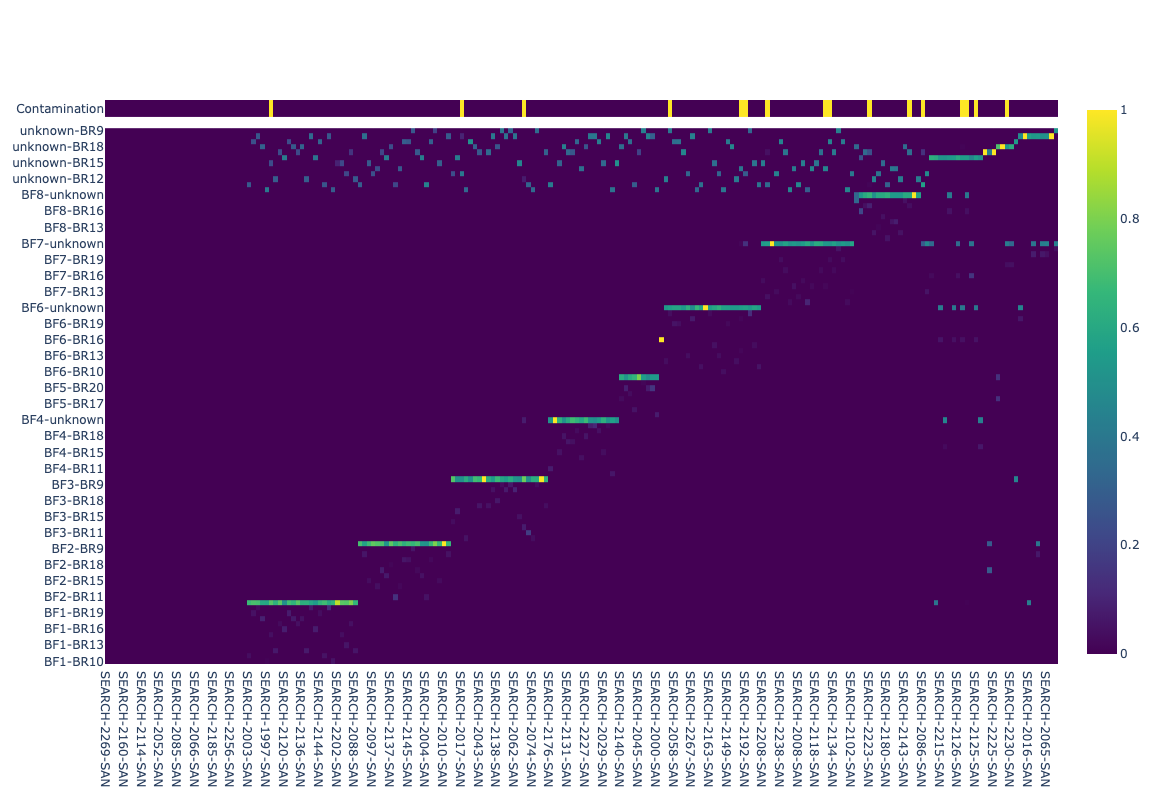

In [79]:
fig.show()

In [76]:
def get_heatmap_data(ans: pd.DataFrame):
    """Sorts the values for the heatmap to make it more intuitive and readable
    Expects a dataframe `ans` containing processed (clean) barcode read counts data
    Expects a dataframe `flag`"""
    # generate heatmap matrix of (logged) read counts per sample per paired read
    hmap = (ans.pivot_table(index=["sample"], columns=["paired_read"], values="paired_read_count")
               .replace([np.inf, -np.inf], np.nan)
               .fillna(0))
    # drop unknown-unknown reads only
    hmap = hmap.drop(columns='unknown-unknown')
    # sort values to make plot more intuitive
    hmap['max_idx'] = hmap.apply(lambda x: hmap.columns.tolist().index(x.idxmax()), axis=1)
    hmap = hmap.sort_values('max_idx').drop(columns=['max_idx'])
    # grab read counts
    counts = hmap.values
    # prepare data for identifying potential contaminants
    flag = (ans.groupby('sample')
               .agg(uniq_forward_bcodes = ('forward_barcode', get_unique_barcodes),
                    uniq_reverse_bcodes = ('reverse_barcode', get_unique_barcodes)))

    # create boolean column that identifies potential contamination
    flag['contamination'] = flag.apply(is_contaminant, axis=1)
    # merge with original data to include the contamination flags
    contaminants_flag = (hmap.join(flag, how='inner')['contamination']
                             .apply(lambda x: np.where(x==True, 1.0, 0.0)))
    # add contaminant flag column to the read counts
    data = np.hstack((counts, contaminants_flag[:, np.newaxis]))
    # list of all sample IDs
    x = hmap.index.values
    # list of all paired reads and an extra flag column for contamination
    y = hmap.columns.tolist()
    return hmap, data, x, y

In [65]:
def get_contaminated_data(data: np.array, hmap: pd.DataFrame):
    # choosing only samples with potential contaminants
    cont_data = data[data[:, -1] !=0][:, :-1]
    # list of samples with potential contamination only
    cont_y = hmap.columns.values[~np.all(cont_data == 0, axis=0)].tolist()
    # data (read counts) for contaminated samples only
    cont_data = cont_data[:, ~np.all(cont_data == 0, axis=0)]
    # list of paired reads with potential contamination only
    cont_x = hmap.index.values[data[:, -1] !=0].tolist()
    return np.hstack((cont_data, np.ones((cont_data.shape[0], 1)))), cont_x, cont_y

In [57]:
# hmap2

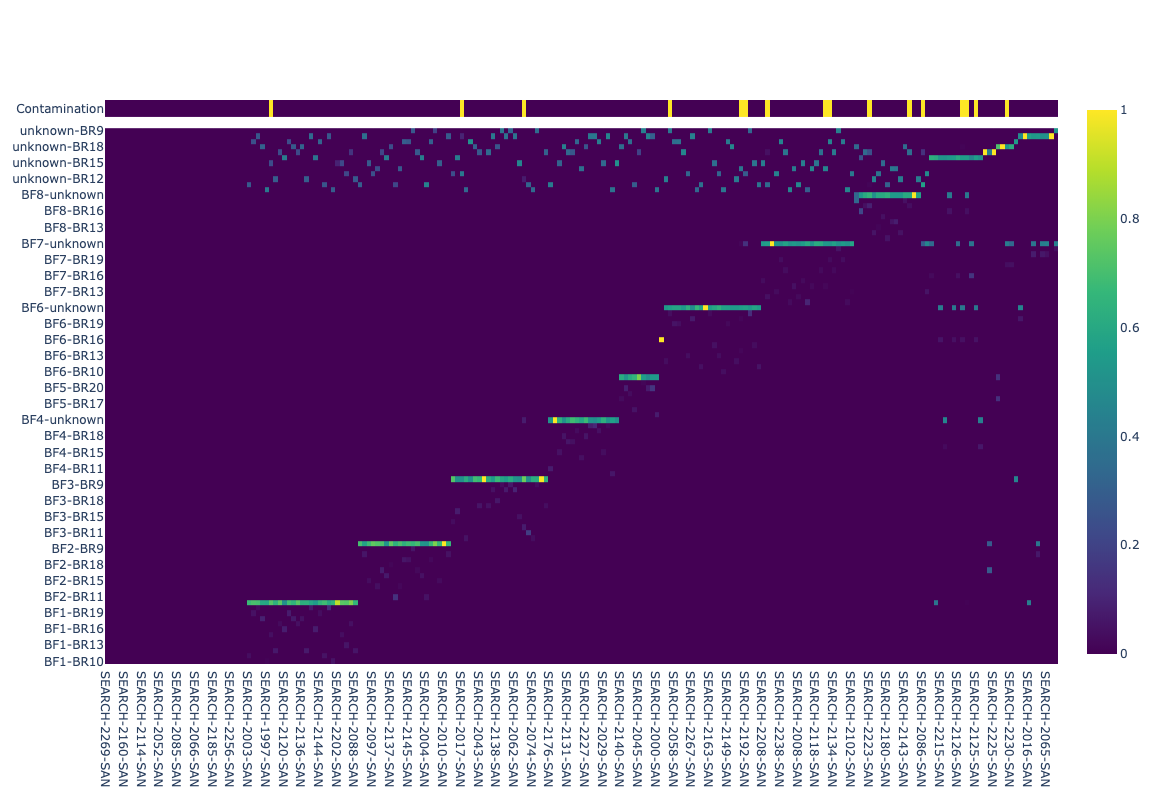

In [58]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# list of all sample IDs
x = hmap2.index.values
# list of all paired reads and an extra flag column for contamination
y = hmap2.columns.tolist()

counts = hmap2.values
# normalize counts per sample (to address visualization issue) - IGNORE IF USING LOG
summed_counts = counts.sum(axis=1)[:, np.newaxis]
# normalize counts [OPTIONAL]
counts = counts / np.where(summed_counts > 0, summed_counts, 1)

fig = make_subplots(2,1, shared_xaxes=True)

fig.add_trace(
 go.Heatmap(z = counts.T, x = x, y = y, coloraxis = "coloraxis"), 2,1)

fig.add_trace(
 go.Heatmap(z = contaminants_flag[:, np.newaxis].T, x=x, y=['Contamination'], coloraxis = "coloraxis"),1,1)
fig.update_layout(coloraxis = {'colorscale':'viridis'}, height=800,
    yaxis=dict(
        domain=[0.97, 1]
    ),
    yaxis2=dict(
        domain=[0, 0.95]
    )
)

fig.show()

In [51]:
data_pth = sample_pths[5]
input_pths = data_pth.listdir()
out_pth = data_pth
num_samples = len(input_pths)
# grab data from each sample
ans = load_all_data(input_pths)
# generate paired reads
ans['paired_read'] = ans.apply(lambda x: x['forward_barcode'] + '-' + x['reverse_barcode'], axis=1)
# compute log of read counts 
ans['log_count'] = ans['paired_read_count'].apply(lambda x: np.log(x+1))
# generate heatmap matrix of (logged: optional) read counts per sample per paired read
# data = get_heatmap_data(ans)
hmap = (ans.pivot_table(index=["sample"], columns=["paired_read"], values="paired_read_count")
           .replace([np.inf, -np.inf], np.nan)
           .fillna(0))
# drop unknown-unknown reads only
hmap = hmap.drop(columns='unknown-unknown')
# grab read counts 
counts = hmap.values
# normalize counts per sample (to address visualization issue) - IGNORE IF USING LOG
summed_counts = counts.sum(axis=1)[:, np.newaxis]
# normalize counts [OPTIONAL]
counts = counts / np.where(summed_counts > 0, summed_counts, 1)
# prepare data for identifying potential contaminants
flag = (ans.groupby('sample')
           .agg(uniq_forward_bcodes = ('forward_barcode', get_unique_barcodes),
                uniq_reverse_bcodes = ('reverse_barcode', get_unique_barcodes)))

# create boolean column that identifies potential contamination
flag['contamination'] = flag.apply(is_contaminant, axis=1)
# getting only samples with potential contamination, not used later but useful to look at
# contaminants = flag[flag['contamination']==True]
# merge with original data to include the contamination flags
contaminants_flag = (hmap.join(flag, how='inner')['contamination']
                         .apply(lambda x: np.where(x==True, counts.max(), counts.min())))
# add contaminant flag column to the read counts
data = np.hstack((counts, contaminants_flag[:, np.newaxis]))
# list of all sample IDs
x = hmap.index.values
# list of all paired reads and an extra flag column for contamination
y = hmap.columns.tolist()
# heatmap of barcode read counts for all samples
general_hmap = generate_heatmap(data, x, y)
# choosing only samples with potential contaminants
contaminated_data = data[data[:, -1] !=0][:, :-1]
# list of samples with potential contamination only
cont_y = hmap.columns.values[~np.all(contaminated_data == 0, axis=0)].tolist()
# data (read counts) for contaminated samples only
contaminated_data = contaminated_data[:, ~np.all(contaminated_data == 0, axis=0)]
# list of paired reads with potential contamination only
cont_x = hmap.index.values[data[:, -1] !=0].tolist()
# heatmap of barcode read counts for contaminated samples only
cont_hmap = generate_heatmap(contaminated_data, cont_x, cont_y)
# table of barcode read counts for contaminated samples only
cont_table = generate_table(ans, cont_x)
# number of contaminated samples
num_conts = len(cont_x)
# generate html string
html_output = generate_html(general_hmap, cont_hmap, cont_table.to_html(),
                            num_samples, num_conts, out_pth)
# save report to file
save_html(html_output, 'contamination_report.html')

In [52]:
hmap.shape

(215, 100)

In [53]:
np.hstack((counts, contaminants_flag[:, np.newaxis])).shape

(215, 101)

In [54]:
hmap.index

Index(['SEARCH-1993-SAN', 'SEARCH-1994-SAN', 'SEARCH-1995-SAN',
       'SEARCH-1996-SAN', 'SEARCH-1997-SAN', 'SEARCH-1998-SAN',
       'SEARCH-1999-SAN', 'SEARCH-2000-SAN', 'SEARCH-2001-SAN',
       'SEARCH-2002-SAN',
       ...
       'SEARCH-2256-SAN', 'SEARCH-2258-SAN', 'SEARCH-2262-SAN',
       'SEARCH-2263-SAN', 'SEARCH-2264-SAN', 'SEARCH-2265-SAN',
       'SEARCH-2266-SAN', 'SEARCH-2267-SAN', 'SEARCH-2268-SAN',
       'SEARCH-2269-SAN'],
      dtype='object', name='sample', length=215)

In [7]:

hmap['max_idx'] = hmap.apply(lambda x: hmap.columns.tolist().index(x.idxmax()), axis=1)
hmap2 = hmap.sort_values('max_idx').drop(columns=['max_idx'])

# merge with original data to include the contamination flags
contaminants_flag = (hmap2.join(flag, how='inner')['contamination']
                         .apply(lambda x: np.where(x==True, counts.max(), counts.min())))

NameError: name 'flag' is not defined

In [68]:
def generate_heatmap(data, x, y, general: bool=True):
    heatmap = go.Heatmap(z=data.T, x=x, y=y)
    plot = [heatmap]
    fig = go.Figure(data = plot)#, layout=go.Layout(
#         annotations=[
#             go.layout.Annotation(
#                 text='Contamination',
#                 align='left',
#                 showarrow=False,
#                 xref='paper',
#                 yref='paper',
#                 x=-0.12,
#                 y=1.05,
#                 bordercolor='black',
#                 borderwidth=0
#             )
#         ]
#     ))
    if general:
        fig.update_layout(title="Contamination Flag (Top Row)",
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="RebeccaPurple"
        )
    )
    return plotly.offline.plot(fig, include_plotlyjs=False, output_type='div')

In [69]:
sample_pths[5]

Path('/home/gk/analysis/2020.08.10.hCoV19/barcode_counts/illumina')

In [70]:
input_pths = sample_pths[5].listdir()
out_pth = sample_pths[0]
expt_pth = sample_pths[5].parent
num_samples = len(input_pths)
# grab data from each sample
ans = load_all_data(input_pths)
# generate paired reads
ans['paired_read'] = ans.apply(lambda x: x['forward_barcode'] + '-' + x['reverse_barcode'], axis=1)
# compute log of read counts 
ans['log_count'] = ans['paired_read_count'].apply(lambda x: np.log(x+1))
# generate heatmap matrix of (logged) read counts per sample per paired read
hmap = (ans.pivot_table(index=["sample"], columns=["paired_read"], values="paired_read_count")
           .replace([np.inf, -np.inf], np.nan)
           .fillna(0))
# drop unknown-unknown reads only
hmap = hmap.drop(columns='unknown-unknown')
# grab read counts 
counts = hmap.values
# normalize counts per sample (to address visualization issue) - IGNORE IF USING LOG
summed_counts = counts.sum(axis=1)[:, np.newaxis]
# normalize counts [OPTIONAL]
counts = counts / np.where(summed_counts > 0, summed_counts, 1)
# prepare data for identifying potential contaminants
flag = (ans.groupby('sample')
           .agg(uniq_forward_bcodes = ('forward_barcode', get_unique_barcodes),
                uniq_reverse_bcodes = ('reverse_barcode', get_unique_barcodes)))

# create boolean column that identifies potential contamination
flag['contamination'] = flag.apply(is_contaminant, axis=1)
# getting only samples with potential contamination, not used later but useful to look at
# contaminants = flag[flag['contamination']==True]
# merge with original data to include the contamination flags
contaminants_flag = (hmap.join(flag, how='inner')['contamination']
                         .apply(lambda x: np.where(x==True, counts.max(), counts.min())))
# add contaminant flag column to the read counts
data = np.hstack((counts, contaminants_flag[:, np.newaxis]))
# list of all sample IDs
x = hmap.index.values
# list of all paired reads and an extra flag column for contamination
y = hmap.columns.tolist() + ['contamination']
# heatmap of barcode read counts for all samples
general_hmap = generate_heatmap(data, x, y)
# choosing only samples with potential contaminants
contaminated_data = data[data[:, -1] !=0][:, :-1]
# list of samples with potential contamination only
cont_y = hmap.columns.values[~np.all(contaminated_data == 0, axis=0)].tolist()
# data (read counts) for contaminated samples only
contaminated_data = contaminated_data[:, ~np.all(contaminated_data == 0, axis=0)]
# list of paired reads with potential contamination only
cont_x = hmap.index.values[data[:, -1] !=0].tolist()
# heatmap of barcode read counts for contaminated samples only
cont_hmap = generate_heatmap(contaminated_data, cont_x, cont_y, general=False)
# table of barcode read counts for contaminated samples only
cont_table = generate_table(ans, cont_x)
# number of contaminated samples
num_conts = len(cont_x)
# generate html string
html_output = generate_html(general_hmap, cont_hmap, cont_table.to_html(),
                            num_samples, num_conts, expt_pth)
# save report to file
save_html(html_output, 'contamination_report.html')